# Coleta e análise de sentimento de tweets

Nesse projeto eu faço coletas de tweets utilizando a api do Twitter através da biblioteca tweepy e realizo análises de sentimento utilizando a biblioteca TextBlob. 

Inicialmente eu analiso tweets sobre alguns líderes mundiais e mostro a porcentagem de tweets negativos, neutros e positivos para cada um. Em seguida, eu faço uma brincadeira e analiso o sentimento sobre os tweets que mencionam a Peppa Pig e também os tweets sobre o Bob Esponja.  Por fim, eu analiso os tweets sobre as séries Stranger Things e Better Caul Saul.

As análises são realizadas nos textos dos últimos 200 tweets a partir do momento de início da coleta, que foi realizada no dia 11 de julho de 2022. Um tweet é classificado como: 'Negativo' se a métrica de polaridade fornecida pelo TextBlob é menor do que -0.1, 'Positivo' se a polaridade é maior do que 0.1 e 'Neutro' se encontra-se entre esses valores. 

Esse projeto foi desenvolvido para práticar técnicas de extração de tweets e explorar o uso das bibliotecas tweepy e TextBlob. Os resultados obtidos não devem ser utilizados para tomar conclusões sobre as avaliações das pessoas, personagens e séries mencionadas. 

Para desenvolver o projeto eu utilizei as seguintes referências:

* vídeo da Kizzy Terra, do canal Programação Dinâmica (https://www.youtube.com/watch?v=RssGfmtyn4A)
* vídeo do Mehran Shakarami, do canal AI Spectrum (https://www.youtube.com/watch?v=Lu1nskBkPJU&t=11s)
* aulas do professor Tulio Philipe para o curso Cientista de Dados da XP educação.


# Importando bibliotecas

In [1]:
import re # utilizada para "limpar" os tweets
import tweepy # utilizada para acessar a api do Twitter 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob # utilizada para realizar as análises de sentimento
from unidecode import unidecode # utilizada para decodificar caracteres não textuais    

In [2]:
import configparser # utilizada para ler as chaves de acesso

config = configparser.ConfigParser()
config.read('config.ini') # lê o arquivo contendo as chaves de acesso

# chaves de acesso à api do Twitter
consumer_key = config['twitter']['consumer_key']
consumer_secret = config['twitter']['consumer_secret']
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

# autenticando o usuário
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [3]:
def clean_tweet(tweet):
    '''
    Remove links e caractéres especiais
    
    :param tweet: string
    
    Retirada do projeto do Pandiyan Murugan 
    que encontra-se no endereço: 
    https://efficientuser.com/2022/05/08/twitter-sentiment-analysis-using-python/
    
    '''
    
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", 
                           " ", tweet).split())

In [4]:
def get_tweets(term):
    """
    Busca por tweets utilizando um termo de entrada ou a junção das palavras do termo de
    entrada
    
    :param term: string 

    """
    
    # separa as palavras contidas na string "term"
    splt = term.split(' ')
    # inicia uma nova string que receberá a junção das palavras
    new_term = ''
    # une as palavras
    for txt in splt:
        new_term = new_term + txt
    
    tweets = tweepy.Cursor(api.search_tweets, 
                q="{} OR {} lang:en -filter:retweets".format(term, new_term), 
                tweet_mode = "extended").items(200)
    

    return tweets

In [5]:
def extract_text(tweets):
    """
    Recebe arquivos de tweets e extrai os textos dos arquivos
    
    :param tweets: tweepy status object
    
    """
    
    text = []

    for tweet in tweets:
        text.append(tweet.full_text)

    return text

In [6]:
def sentiment(text):
    """
    Recebe os textos dos tweets e analisa o sentimento
    
    :param text: lista de strings
    
    """

    s = []

    for txt in text:
        decoded = unidecode(txt) # remove elementos não textuais
        senti = TextBlob(clean_tweet(str(decoded)))
        polarity = senti.polarity
        if polarity < -0.1:
            s.append('Negativo')
        elif polarity > 0.1:
            s.append('Positivo')
        else:
            s.append('Neutro')
    
    return s

In [7]:
def sentiment_fraction(sentiments):
    """
    Recebe uma lista com os sentimentos e retorna um dicionário 
    com a porcentagem de cada sentimento
    
    :param sentiments: lista de strings
    
    """

    series = pd.Series(sentiments)

    tot = len(series)
    num_pos = sum(series == 'Positivo')
    num_neg = sum(series == 'Negativo')
    num_neu = tot - num_pos - num_neg

    return {'Positivo' : num_pos * 100 / tot, 
            'Neutro' : num_neu * 100 / tot, 
            'Negativo' : num_neg * 100 / tot}

A primeira análise é feita sobre alguns líderes mundiais. Na lista a seguir eu descrevo o nome dos líderes.

In [8]:
politicians = ['Justin Trudeau',
               'Jacinda Ardern',
               'Boris Johnson',
               'Joe Biden']

In [9]:
def sentiment_df(terms):
    """
    Recebe termos de busca e constrói um dataframe
    com a porcentagem dos sentimentos para cada termo
    
    :param terms: dictionary of search terms
    
    """
    
    df = pd.DataFrame()

    for name in terms:
        tweets = get_tweets(name) # coleta os tweets   
        tweet_text = extract_text(tweets) # extrai somente o texto dos tweets 
        sentim_list = sentiment(tweet_text) # analisa o sentimento de cada tweet
        fraction = sentiment_fraction(sentim_list) # obtém a porcentagem de cada sentimento
        df = df.append(fraction, ignore_index = True) 
    
    df['Names'] = terms
    df = df.set_index(['Names']) 
    
    return df

In [63]:
# constrói um dataframe com os sentimentos sobre os políticos
df_politicians = sentiment_df(politicians)

In [64]:
df_politicians.sort_values('Positivo', ascending = False)

,Negativo,Neutro,Positivo
Names,,,
Jacinda Ardern,13.5,52.5,34.0
Justin Trudeau,17.5,51.0,31.5
Boris Johnson,12.0,62.0,26.0
Joe Biden,25.5,51.5,23.0


In [14]:
def barplot_sentiments(df):
    """
    Cria um stacked barplot horizontal com os sentimentos contidos
    em cada linha do dataframe
    
    :param df: pandas dataframe
    
    """
    
    df = df.sort_values('Positivo', ascending = True)
    sns.set(style='white')

    df.plot(kind='barh', stacked=True, color=['red', 'gray', 'green'])
 
    # labels para os eixos x e y 
    plt.xlabel('%')
    plt.ylabel('')
    # título do plot
    plt.title('Análise de sentimento de tweets\n', fontsize = 16)
    # adiciona legenda 
    plt.legend(bbox_to_anchor =(1.3, .85), frameon = False)

    plt.show()

In [ ]:
# cria um barplot para os sentimentos dos políticos
barplot_sentiments(df_politicians)

Agora a análise será realizada nos tweets sobre os personagens infantis Peppa Pig e Bob Esponja.

In [10]:
# cria uma lista com o nome dos personagens 
personagens = ['Peppa Pig',
               'Sponge Bob']

In [11]:
# cria um datafram com os sentimentos sobre os personagens
df_personagens = sentiment_df(personagens)

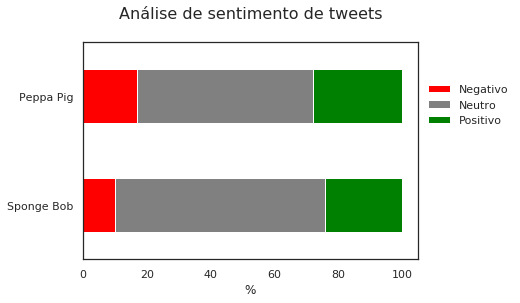

In [15]:
# desenha um barplot horizontal com os percentuais de cada sentimento dos personagens 
barplot_sentiments(df_personagens)

In [69]:
# séries de tv 
tv_series = ['Stranger Things',
          'Better Call Saul']

In [70]:
# constrói o dataframe com os sentimentos sobre as séries
df_series = sentiment_df(tv_series)

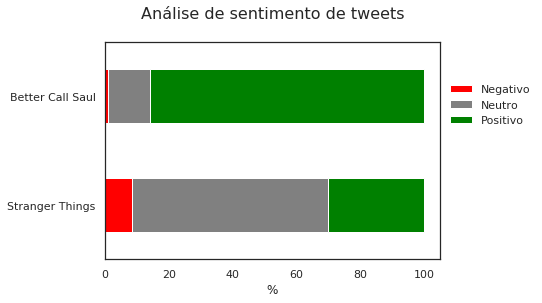

In [74]:
# desenha o gráfico de barras horizontais contendo as frações correspondentes dos sentimentos
barplot_sentiments(df_series)